In [2]:
%load_ext autoreload
%autoreload 2

import sys
import os
import time

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %matplotlib notebook

sys.path.append(os.environ['REPO_DIR'] + '/utilities')
from utilities2015 import *
from registration_utilities import *
from metadata import *
from data_manager import *

Setting environment for Precision WorkStation


No vtk


In [3]:
atlas_name = 'atlasV5'

In [4]:
fp = DataManager.get_instance_centroids_filepath(atlas_name=atlas_name)
download_from_s3(fp)
instance_centroids_rel2fixed = load_pickle(fp)

In [ ]:
# ann_vol_bbox_rel2uncropped = DataManager.load_original_volume_bbox(stack='MD589', volume_type='annotation', downscale=32)
# print 'annotation volume bbox (rel2uncropped):', ann_vol_bbox_rel2uncropped

In [13]:
from registration_utilities import *

In [14]:
canonical_locations_rel2canon, _, canonical_centroid_rel2fixed, canonical_normal, _ = \
average_location(instance_centroids_rel2fixed)

# canonical_centroid_rel2uncropped = canonical_centroid_rel2fixed + ann_vol_bbox_rel2uncropped[[0,2,4]]
# print 'canonical_centroid_rel2uncropped', canonical_centroid_rel2uncropped

Mid-sagittal plane normal vector = [ 0.04111027 -0.09160432  0.99494653]
Mid-sagittal plane anchor = [172.0630378  223.21016434 186.74030921]
Transform matrix to canonical atlas space =
[[ 9.99153001e-01  1.88733304e-03 -4.11102722e-02 -1.64661628e+02]
 [ 1.88733304e-03  9.95794534e-01  9.16043196e-02 -2.39702421e+02]
 [ 4.11102722e-02 -9.16043196e-02  9.94947535e-01 -1.72423353e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Angular deviation around y axis (degree) = 5.762561993810122


In [15]:
canonical_locations_rel2fixed = {k: canonical_centroid_rel2fixed + c_rel2canon 
                                 for k, c_rel2canon in canonical_locations_rel2canon.iteritems()}

In [16]:
print 'deviation angle:', np.rad2deg(np.arccos(canonical_normal[2]))

deviation angle: 5.762561993810122


In [17]:
canonical_midplane_xx, canonical_midplane_yy = np.meshgrid(range(0, 500, 100), range(0, 500, 100), indexing='xy')
canonical_midplane_z = -(canonical_normal[0]*(canonical_midplane_xx-canonical_centroid_rel2fixed[0]) + \
canonical_normal[1]*(canonical_midplane_yy-canonical_centroid_rel2fixed[1]) + \
canonical_normal[2]*(-canonical_centroid_rel2fixed[2]))/canonical_normal[2]

In [18]:
# radii_allStructures = {}
# ellipsoid_matrix_allStructures = {}
# for name_s, centroids in sorted(instance_centroids_rel2fixed.items()):
#     centroids2 = np.array(centroids)
#     cov_mat = np.cov(centroids2.T)
#     u, s, vt = np.linalg.svd(cov_mat)
# #     print name_s, u[:,0], u[:,1], u[:,2],
#     radii_allStructures[name_s] = np.sqrt(s)
#     ellipsoid_matrix_allStructures[name_s] = vt

In [19]:
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt

# fig = plt.figure(figsize=(10, 10))
# ax = fig.add_subplot(111, projection='3d')

# for name_s, centroids in instance_centroids_rel2fixed.iteritems():
# #     if name_s == '7N_L' or name_s == '7N_R':
#     centroids2 = np.array(centroids)
#     ax.scatter(centroids2[:,0], centroids2[:,1], centroids2[:,2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                marker='o', s=100, alpha=.1)
    
#     c = canonical_locations_rel2fixed[name_s]
#     ax.scatter(c[0], c[1], c[2], 
#                color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)
    
#     # Plot uncerntainty ellipsoids
#     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     v = np.linspace(0.0, np.pi, 100)
#     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     for i in range(len(u)):
#         for j in range(len(v)):
#             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

# #     ax.plot_surface(x, y, z, color='b')
#     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)
    
# ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#            color=(0,0,0), marker='^', s=200)

# # Plot mid-sagittal plane
# ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

# # ax.set_xlabel('X Label')
# # ax.set_ylabel('Y Label')
# # ax.set_zlabel('Z Label')
# # ax.set_axis_off()
# ax.set_xlim3d([0, 400]);
# ax.set_ylim3d([0, 400]);
# ax.set_zlim3d([0, 400]);
# # ax.view_init(azim = 90 + 20,elev = 0 - 20)
# ax.view_init(azim = 90,elev = 0)
# ax.set_aspect(1.0)
# plt.legend()
# plt.show()

In [18]:
from collections import defaultdict

In [19]:
# Load human correction.

human_correction_transforms = defaultdict(dict)

for stack_fixed in all_nissl_stacks:

    structures = load_hdf_v2(DataManager.get_annotation_filepath(stack=stack_fixed, 
                                                by_human=True,
                               timestamp='latest', suffix='structures'))

    for _, entry in structures.iterrows():

        tf = np.eye(4)
        edits = entry['edits']
        for edit in edits:
            if 'type' in edit:
                if edit['type'] == 'shift3d' or edit['type'] == 'rotation3d':
                    T = consolidate(edit['transform'], edit['centroid_m'], edit['centroid_f'])
                    tf = np.dot(tf, T)
        print entry['name'], entry['side'], tf[:3,-1]

        name_s = compose_label(structure_name=entry['name'], side=entry['side'])
        human_correction_transforms[stack_fixed][name_s] = tf

    print '\n'
    
human_correction_transforms.default_factory = None

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD585" "/home/yuncong/CSHL_labelings_v3/MD585" --exclude "*" --include "*structures*"
return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/home/yuncong/CSHL_labelings_v3/MD589" --exclude "*" --include "*structures*"


latest timestamp:  11012017011336
SNC R [  69.67381098 -121.02943746  320.08680801]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD590" "/home/yuncong/CSHL_labelings_v3/MD590" --exclude "*" --include "*structures*"


latest timestamp:  10312017220310
3N L [12.97114132 -3.29425811 -8.39212254]
3N R [-1.48241615 -0.82356453 78.07391729]
4N R [23.75616484 11.29005854  0.        ]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD591" "/home/yuncong/CSHL_labelings_v3/MD591" --exclude "*" --include "*structures*"


latest timestamp:  10312017221118
3N L [  0.           0.55147171 -24.69805423]
4N R [12.70131586  7.19741232  0.        ]
3N R [ 0.         -0.03939084 28.47957449]
4N L [91.28828467 54.90430189 25.93635298]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD592" "/home/yuncong/CSHL_labelings_v3/MD592" --exclude "*" --include "*structures*"


latest timestamp:  11012017004215
3N L [-16.6804119    0.         -88.37435272]
3N R [  0.66708727   0.         -15.34300716]
PBG L [-47.05872473 -63.65824338 143.56690968]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD593" "/home/yuncong/CSHL_labelings_v3/MD593" --exclude "*" --include "*structures*"


latest timestamp:  11012017004455
3N L [0. 0. 0.]
3N R [0. 0. 0.]
PBG L [-108.85949815  -24.08460263  162.18962673]
4N R [140.74772646 -12.14230207  33.3543634 ]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD594" "/home/yuncong/CSHL_labelings_v3/MD594" --exclude "*" --include "*structures*"


latest timestamp:  11012017012940
PBG R [-74.82430621  97.13871499 -40.76644415]
3N R [ -0.06631864   0.         -46.74219986]
SNC R [  16.47129057 -133.00263783  338.91544378]
3N L [ 2.47069359  0.         32.94258114]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD595" "/home/yuncong/CSHL_labelings_v3/MD595" --exclude "*" --include "*structures*"


latest timestamp:  11012017013215
3N L [  0.          12.02404211 -42.0841474 ]
SNC R [   0.         -123.22463439  184.06497752]
3N R [ 0.          5.60023879 12.51818083]
6N R [ -36.98990972   78.03328876 -212.78835972]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD598" "/home/yuncong/CSHL_labelings_v3/MD598" --exclude "*" --include "*structures*"


latest timestamp:  11012017005748
PBG R [ 71.57498746 -26.22601054  17.2948551 ]
PBG L [-208.90092292 -173.58400474  -51.14335721]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD599" "/home/yuncong/CSHL_labelings_v3/MD599" --exclude "*" --include "*structures*"


latest timestamp:  11012017013514
SNC R [   0.         -233.02624968  202.60656684]
PBG L [-117.31046585    3.93411796  121.55812439]
3N L [ 16.30657766   0.         -66.7087268 ]
4N L [131.45600567 -43.50666485 -10.26647305]
PBG R [-73.15936018  61.77216157 -34.09557147]
3N R [11.36519049  0.          2.71776294]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD602" "/home/yuncong/CSHL_labelings_v3/MD602" --exclude "*" --include "*structures*"


latest timestamp:  10312017205108
3N R [0. 0. 0.]
6N R [-156.14514172   27.08640214    0.        ]
3N L [  0.         -5.7649517 -55.1788234]
PBG R [188.6340782    4.35573246 -71.15597525]




return code: 0
aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD603" "/home/yuncong/CSHL_labelings_v3/MD603" --exclude "*" --include "*structures*"


latest timestamp:  10312017205515
3N R [ 0.         12.25492678 34.13872461]
3N L [ 28.24295365   0.         -22.59436292]


latest timestamp:  10312017211410
3N L [ -0.77003283   0.         -34.3154632 ]
PBG R [  3.98329443 -52.75740363 -21.46464477]
VLL R [   0.      440.8992 -157.464 ]
3N R [-3.87502244 13.35757955 46.94317812]




return code: 0


In [227]:
from data_manager import *

In [23]:
adjustments_global_pos_to_local_pos = defaultdict(dict)
adjustments_local_pos_to_human_pos = defaultdict(dict)

adjusted_structure_centroids_rel2atlas = defaultdict(dict)

for s in all_known_structures_sided:
    try:
        c = canonical_locations_rel2fixed[s]
        for stack in all_nissl_stacks:
            global_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, 
                                                  stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=20)

            Gas = consolidate(global_params, centroid_m, centroid_f)

            local_params, centroid_m, centroid_f, _,_,_,_,_,_ = \
            DataManager.load_alignment_parameters(stack_m=atlas_name, 
                                                  stack_f=stack,
                                                  prep_id_f=2,
                                                  detector_id_f=15,
                                                  warp_setting=17,
                                                  structure_f=s,
                                                  structure_m=s)
            Lss = consolidate(local_params, centroid_m, centroid_f)
            
            adjustments_global_pos_to_local_pos[s][stack] = Lss[:3, 3]
            
            #################################
           
            if s in human_correction_transforms[stack]:
                tf_guiVolResol = human_correction_transforms[stack][s]
                tf_volResol = tf_guiVolResol.copy()
                tf_volResol[:3,3] = tf_guiVolResol[:3,3]/4.
                Lss = np.dot(tf_volResol, Lss)
                
                adjustments_local_pos_to_human_pos[s][stack] = tf_volResol[:3, 3]
            else:
#                 adjustments_local_pos_to_human_pos[s][stack] = np.eye(4)
                adjustments_local_pos_to_human_pos[s][stack] = np.array([0,0,0])

            ##################################
            
            Gas_inv = np.linalg.inv(Gas)
            Laa = np.dot(Gas_inv, np.dot(Lss, Gas))
            
            ##################################
                    
            adjusted_structure_centroids_rel2atlas[s][stack] = np.dot(Laa[:3, :3], c) + Laa[:3, 3]
    except Exception as e:
        sys.stderr.write("Cannot compute centroid in atlas space for %s: %s\n" % (s, e))
        
adjusted_structure_centroids_rel2atlas.default_factory = None

adjustments_global_pos_to_local_pos.default_factory = None
adjustments_local_pos_to_human_pos.default_factory = None

In [25]:
DataFrame(adjusted_structure_centroids_rel2atlas).to_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/UpdateAtlas/measurements/adjusted_structure_centroids_rel2atlas_um.csv')

# Summarize local to human difference

In [232]:
import pandas as pd

In [233]:
pd.DataFrame(adjustments_local_pos_to_human_pos)

,10N_L,10N_R,12N,3N_L,3N_R,4N_L,4N_R,5N_L,5N_R,6N_L,...,Sp5O_L,Sp5O_R,Tz_L,Tz_R,VCA_L,VCA_R,VCP_L,VCP_R,VLL_L,VLL_R
MD585,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD589,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[3.2427853304907046, -0.8235645283785971, -2.0...","[-0.370604037770363, -0.20589113209464927, 19....","[0, 0, 0]","[5.939041210595349, 2.8225146347383543, 0.0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD590,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, 0.13786792630568812, -6.174513556691235]","[0.0, -0.009847709021840956, 7.119893622787487]","[22.822071167408694, 13.72607547297659, 6.4840...","[3.175328964080677, 1.7993530796457264, 0.0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD591,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[-4.170102975690298, 0.0, -22.09358818057774]","[0.16677181699665766, 0.0, -3.8357517909232968]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD592,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, 0.0, 0.0]","[0.0, 0.0, 0.0]","[0, 0, 0]","[35.1869316161154, -3.0355755168469054, 8.3385...","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD593,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.6176733962839478, 0.0, 8.23564528378597]","[-0.016579659826760462, 0.0, -11.685549966176552]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD594,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, 3.006010528581868, -10.521036850036552]","[0.0, 1.4000596982436093, 3.129545207838646]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD595,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD598,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[4.07664441547405, 0.0, -16.677181699666562]","[2.841297622906154, 0.0, 0.6794407359123227]","[32.86400141836589, -10.876666213487624, -2.56...","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"
MD599,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0.0, -1.4412379246625164, -13.79470585034147]","[0.0, 0.0, 0.0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]",...,"[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]","[0, 0, 0]"


In [277]:
adjustment_vector_local_pos_to_human_pos_um = \
{name_s: {stack: adj_xyz * convert_resolution_string_to_um(resolution='down32', stack=stack)
             for stack, adj_xyz in data_all_structures.iteritems()}
for name_s, data_all_structures in adjustments_local_pos_to_human_pos.iteritems()}

In [280]:
adjustment_distance3d_local_to_human_um = {name_s: {stack: np.linalg.norm(adj_xyz)
         for stack, adj_xyz in data_all_structures.iteritems()}
    for name_s, data_all_structures in adjustment_vector_local_pos_to_human_pos_um.iteritems()}

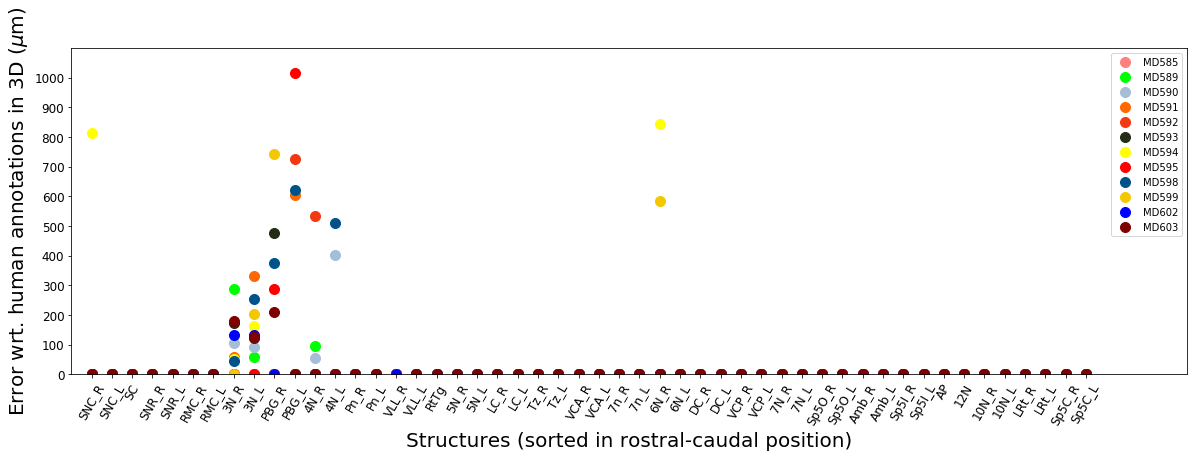

In [283]:
plot_by_stack_by_structure(pd.DataFrame(adjustment_distance3d_local_to_human_um).T.to_dict(), 
                          structures=structures_sided_sorted_by_rostral_caudal_position,
                          yticks=np.arange(0, 1000+1, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position)+4],
                          xlabel='Structures (sorted in rostral-caudal position)',
                           ylabel='Error wrt. human annotations in 3D ($\mu$m)');

In [284]:
DataFrame(adjustment_vector_local_pos_to_human_pos_um).to_csv('/home/yuncong/adjustment_vector_local_pos_to_human_pos_um.csv')

## Summarize global to local adjustment

In [234]:
pd.DataFrame(adjustments_global_pos_to_local_pos)

,10N_L,10N_R,12N,3N_L,3N_R,4N_L,4N_R,5N_L,5N_R,6N_L,...,Sp5O_L,Sp5O_R,Tz_L,Tz_R,VCA_L,VCA_R,VCP_L,VCP_R,VLL_L,VLL_R
MD585,"[79.57776831840488, -37.76458344803706, -66.69...","[107.36429639458544, -61.41703841703321, -72.6...","[33.49802199161144, -17.846111155446636, -30.8...","[-10.911627447414588, 8.38604807649142, 2.7407...","[7.828795882591777, 0.8725088627791138, -1.774...","[2.1258856281096428, -1.1732736209051495, 1.18...","[-1.5784583902972429, 2.6829136082376692, 1.08...","[2.802168870750222, 1.0661078728529674, -12.23...","[13.679063366068505, -6.046015280612323, 4.794...","[6.877112084374744, -5.1866953453020415, -1.66...",...,"[11.561620783198066, -14.360765107132352, 18.4...","[46.256746229566374, -4.891137243876756, -41.3...","[30.949228486315178, -3.92334005519308, -21.76...","[5.920032419206393, -5.056237965923799, 5.9591...","[2.4057349949793263, -2.897429976905954, -21.5...","[14.471464768802662, -3.7845422425145046, 6.43...","[-0.30193197439490405, 1.5235245899788197, -15...","[14.008397606475512, -9.640553464498566, 11.52...","[17.918479018933567, 1.2275655757765094, -29.3...","[6.804282829477728, -23.166513429310015, 31.46..."
MD589,"[-4.860369413686271, 6.956214030953788, 5.2632...","[-4.48143518793114, 7.090643727430859, 1.19287...","[-7.594716666903992, 5.292602150207131, 2.0906...","[6.418181449761818, -1.285909798963388, -1.752...","[-4.622119905883409, -0.30664641826217576, -12...","[6.5510841767977865, 4.645170736893107, -5.103...","[5.830246000436205, 9.131858246157378, 1.27510...","[-0.25522729661386734, 4.860930991701309, -5.2...","[5.091187173200666, -10.069582153889058, 17.45...","[1.7805964256944549, 3.9987510531892383, -4.93...",...,"[-5.193238786897155, -1.1924833725067288, 31.8...","[24.599519794215155, 9.861199308711747, -22.10...","[6.595837693031768, -1.8323132985370876, 2.021...","[-2.84993310574626, 2.280787402561714, 7.91980...","[-8.044994103870238, 1.8798922031627114, -18.4...","[-10.667186559546053, 3.3998105936332763, 13.0...","[-5.347929509152323, 1.2147473159973288, -2.34...","[6.193660785054021, -3.3593140655434865, 11.90...","[19.62795291706979, -15.831713584762781, -24.0...","[7.329209807121941, -35.81081937843291, 31.568..."
MD590,"[15.836502461684518, -4.824511723196565, -24.1...","[7.90805651809211, -1.7141577683759124, -19.93...","[-0.26537225658807984, -0.4655928810863088, -2...","[-11.572786036161375, 10.185543174524469, 5.38...","[-17.102300452830008, 11.020882143596339, -8.7...","[-16.13556896570256, -12.890394548965219, -9.8...","[-20.979856999031853, -2.951602882411379, -14....","[7.15997374872785, 3.539103394827066, -12.4279...","[9.799997957091506, -7.706792468495166, 8.0690...","[3.8158894328386737, -1.331628763732624, 2.756...",...,"[8.807759769571248, -15.008074103651268, 31.37...","[12.341868810475376, 0.6984558739301292, -12.2...","[-9.016567969120047, 9.496518781896839, 0.4387...","[4.2604812240369085, -4.709154547277876, 8.835...","[-3.912777079826526, -3.859188449724911, -20.2...","[-0.03418308612151577, -8.005264387046736, 13....","[9.58881099763812, -14.479465363827728, -17.20...","[16.43096202339592, -29.970420807098634, 17.55...","[26.543450233697783, -5.96074944308549, -27.58...","[18.535684554577273, -44.36125641399633, 31.15..."
MD591,"[-8.336965543115923, -3.655027222304625, 10.91...","[-5.042228628763041, 4.932382460081385, 9.0798...","[-11.429920101501523, 1.6070227077124741, 5.94...","[1.9713429490735166, 0.33070592449874425, 1.41...","[4.618710460553771, 0.8581508685050778, 0.0955...","[3.1969566341308564, 6.494377316474441, 0.2345...","[2.224755849627144, 4.1263187341918695, 1.0282...","[15.785103030294522, 0.12678976631752903, -10....","[19.19978959557767, -14.555301015274154, 8.978...","[1.3350105962254304, 3.725426540113915, 4.5292...",...,"[-8.562573234900867, 2.0224833207066695, 38.24...","[39.98793186782632, -8.01626932062743, -25.513...","[-1.3441843544213157, 4.672286972729864, 3.415...","[2.1586860967951225, -2.4582422914512563, 8.45.

In [266]:
adjustment_vector_global_pos_to_local_pos_um = \
{name_s: {stack: adj_xyz * convert_resolution_string_to_um(resolution='down32', stack=stack)
             for stack, adj_xyz in adj_all_structures.iteritems()}
for name_s, adj_all_structures in adjustments_global_pos_to_local_pos.iteritems()}

In [267]:
adjustment_distance3d_global_to_local_um = {name_s: {stack: np.linalg.norm(adj_xyz)
         for stack, adj_xyz in adj_all_structures.iteritems()}
    for name_s, adj_all_structures in adjustment_vector_global_pos_to_local_pos_um.iteritems()}

adjustment_x_global_to_local_um = {name_s: {stack: adj_xyz[0]
         for stack, adj_xyz in adj_all_structures.iteritems()}
    for name_s, adj_all_structures in adjustment_vector_global_pos_to_local_pos_um.iteritems()}

adjustment_y_global_to_local_um = {name_s: {stack: adj_xyz[1]
         for stack, adj_xyz in adj_all_structures.iteritems()}
    for name_s, adj_all_structures in adjustment_vector_global_pos_to_local_pos_um.iteritems()}

adjustment_z_global_to_local_um = {name_s: {stack: adj_xyz[2]
         for stack, adj_xyz in adj_all_structures.iteritems()}
    for name_s, adj_all_structures in adjustment_vector_global_pos_to_local_pos_um.iteritems()}

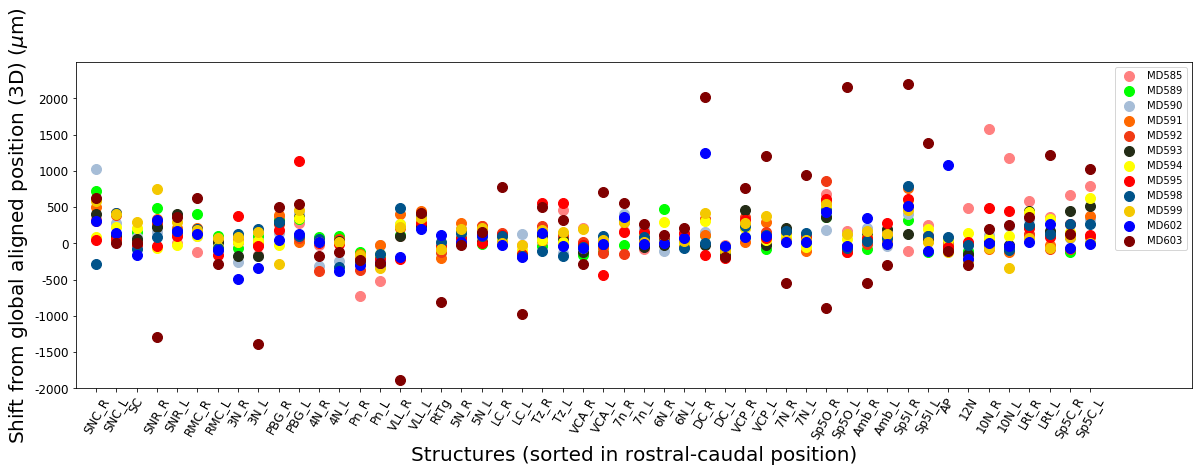

In [275]:
plot_by_stack_by_structure(pd.DataFrame(adjustment_x_global_to_local_um).T.to_dict(), 
                          structures=structures_sided_sorted_by_rostral_caudal_position,
                          yticks=np.arange(-2000, 2000+1, 500),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position)+4],
                          xlabel='Structures (sorted in rostral-caudal position)',
                           ylabel='Shift from global aligned position (3D) ($\mu$m)');

In [276]:
DataFrame(adjustment_vector_global_pos_to_local_pos_um).to_csv('/home/yuncong/adjustment_vector_global_pos_to_local_pos_um.csv')

# Compute average centroids from instance centroids

In [27]:
new_nominal_centroids_rel2atlas_allstructures = {}
instance_centroids_deviations_allstructures_rel2nominal = defaultdict(dict)
for s, centroids_rel2atlas_allstacks in adjusted_structure_centroids_rel2atlas.iteritems():
    new_nominal_centroids_rel2atlas_allstructures[s] = np.mean(centroids_rel2atlas_allstacks.values(), axis=0)
    for st, c in centroids_rel2atlas_allstacks.iteritems():
        instance_centroids_deviations_allstructures_rel2nominal[s][st] = c - new_nominal_centroids_rel2atlas_allstructures[s]

In [44]:
instance_centroids_deviations_allstructures_rel2nominal_um = {name_s: {st: c * XY_PIXEL_DISTANCE_LOSSLESS * 32
for st, c in x.iteritems()}
for name_s, x in instance_centroids_deviations_allstructures_rel2nominal.iteritems()}

In [57]:
pd.DataFrame(instance_centroids_deviations_allstructures_rel2nominal_um).to_csv('/home/yuncong/Dropbox/BrainProjectFiguresByTopic/UpdateAtlas/measurements/instance_centroids_deviation_3d_from_mean_all_stacks_all_structures_um.csv')

In [30]:
# Identify outlier

outliers_allstructures = {}
# dxs_allstructures_outlierRemoved = {}
new_nominal_centroids_rel2atlas_allstructures_outlierRemoved = {}

for s, ps_allstacks in sorted(instance_centroids_deviations_allstructures_rel2nominal.items()):
    vals = np.linalg.norm(np.array(ps_allstacks.values()), axis=1)
    first_quartile = np.percentile(vals, 20)
    third_quartile = np.percentile(vals, 80)
    IQR = third_quartile - first_quartile
    is_outlier = (vals < first_quartile - 1 * IQR) | (vals > third_quartile + 1 * IQR)
#     dxs_allstructures_outlierRemoved[s] = vals[~is_outlier]
    
#     if np.count_nonzero(is_outlier) > 0:
    outlier_indices = np.where(is_outlier)[0]
    outliers_allstructures[s] = [ps_allstacks.keys()[i] for i in outlier_indices]

    print s, outliers_allstructures[s]
    
    new_nominal_centroids_rel2atlas_allstructures_outlierRemoved[s] = \
    np.mean([adjusted_structure_centroids_rel2atlas[s][st]
             for st in set(ps_allstacks.keys())-set(outliers_allstructures[s])], 
            axis=0)
    
#     mu = np.mean(ps)
#     std = np.std(ps)
#     txs_allLandmarks_outlierRemoved[n] = np.array(ps)[np.abs(ps - mu) < 2. * std]
    
# write_dict_to_txt(outliers, '/home/yuncong/Brain/outliers.txt', fmt='%s')

10N_L []
10N_R []
12N ['MD585']
3N_L ['MD591']
3N_R ['MD593']
4N_L ['MD602']
4N_R ['MD590', 'MD589']
5N_L []
5N_R ['MD603']
6N_L ['MD585']
6N_R []
7N_L ['MD598']
7N_R []
7n_L []
7n_R ['MD591', 'MD585']
AP []
Amb_L ['MD590']
Amb_R []
DC_L ['MD603', 'MD595']
DC_R []
IC ['MD603']
LC_L ['MD593']
LC_R []
LRt_L []
LRt_R []
PBG_L ['MD598']
PBG_R ['MD599']
Pn_L []
Pn_R ['MD603']
RMC_L []
RMC_R ['MD585']
RtTg []
SC ['MD592', 'MD603', 'MD589']
SNC_L []
SNC_R []
SNR_L ['MD595', 'MD598']
SNR_R []
Sp5C_L []
Sp5C_R []
Sp5I_L ['MD603']
Sp5I_R ['MD585']
Sp5O_L []
Sp5O_R ['MD603', 'MD598']
Tz_L []
Tz_R []
VCA_L ['MD595']
VCA_R []
VCP_L ['MD595']
VCP_R ['MD595']
VLL_L ['MD595']
VLL_R ['MD603']


In [29]:
# OR ignore outlier 

outliers_allstructures = {}
# dxs_allstructures_outlierRemoved = {}
new_nominal_centroids_rel2atlas_allstructures_outlierRemoved = {}

for s, ps_allstacks in sorted(instance_centroids_deviations_allstructures_rel2nominal.items()):
    outliers_allstructures[s] = {} 

    print s, outliers_allstructures[s]
    
    new_nominal_centroids_rel2atlas_allstructures_outlierRemoved[s] = \
    np.mean([adjusted_structure_centroids_rel2atlas[s][st]
             for st in set(ps_allstacks.keys())-set(outliers_allstructures[s])], 
            axis=0)
    
#     mu = np.mean(ps)
#     std = np.std(ps)
#     txs_allLandmarks_outlierRemoved[n] = np.array(ps)[np.abs(ps - mu) < 2. * std]
    
# write_dict_to_txt(outliers, '/home/yuncong/Brain/outliers.txt', fmt='%s')

10N_L {}
10N_R {}
12N {}
3N_L {}
3N_R {}
4N_L {}
4N_R {}
5N_L {}
5N_R {}
6N_L {}
6N_R {}
7N_L {}
7N_R {}
7n_L {}
7n_R {}
AP {}
Amb_L {}
Amb_R {}
DC_L {}
DC_R {}
IC {}
LC_L {}
LC_R {}
LRt_L {}
LRt_R {}
PBG_L {}
PBG_R {}
Pn_L {}
Pn_R {}
RMC_L {}
RMC_R {}
RtTg {}
SC {}
SNC_L {}
SNC_R {}
SNR_L {}
SNR_R {}
Sp5C_L {}
Sp5C_R {}
Sp5I_L {}
Sp5I_R {}
Sp5O_L {}
Sp5O_R {}
Tz_L {}
Tz_R {}
VCA_L {}
VCA_R {}
VCP_L {}
VCP_R {}
VLL_L {}
VLL_R {}


In [31]:
instance_centroids_deviations_allstructures_rel2nominal_outlier_removed = \
{name_s: [v for st, v in instance_centroids_deviations_allstructures_rel2nominal[name_s].iteritems()
                    if st not in outliers_allstructures[name_s]]
for name_s in all_known_structures_sided}

In [32]:
cov_mat_allStructures, radii_allStructures, ellipsoid_matrix_allStructures = \
compute_covar_from_instance_centroids(instance_centroids_deviations_allstructures_rel2nominal_outlier_removed)

In [33]:
updated_nominal_locations_rel2canon, _, updated_canonical_centroid_rel2atlas, updated_canonical_normal, _ = \
average_location(mean_centroid_allLandmarks=new_nominal_centroids_rel2atlas_allstructures_outlierRemoved)

Mid-sagittal plane normal vector = [ 7.73461911e-04 -2.57011631e-03  9.99996398e-01]
Mid-sagittal plane anchor = [172.26421688 224.49427458 187.31682433]
Transform matrix to canonical atlas space =
[[ 9.99999703e-01  9.86580007e-07 -7.73461911e-04 -1.72119505e+02]
 [ 9.86580007e-07  9.99996722e-01  2.57011631e-03 -2.24975135e+02]
 [ 7.73461911e-04 -2.57011631e-03  9.99996425e-01 -1.86872418e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Angular deviation around y axis (degree) = 0.15378083118141236


In [36]:
print 'new canonical centroid wrt atlasSpace', updated_canonical_centroid_rel2atlas

new canonical centroid wrt atlasSpace [172.26421688 224.49427458 187.31682433]


In [37]:
updated_nominal_locations_rel2atlas = {k: updated_canonical_centroid_rel2atlas + c 
                                         for k, c in updated_nominal_locations_rel2canon.iteritems()}

In [38]:
print 'deviation angle:', np.rad2deg(np.arccos(updated_canonical_normal[2]))

deviation angle: 0.15378083118141236


In [39]:
updated_canonical_centroid_rel2atlas

array([172.26421688, 224.49427458, 187.31682433])

In [40]:
instance_centroids_deviations_allstructures_rel2canon_outlier_removed = \
{name_s: xs + new_nominal_centroids_rel2atlas_allstructures_outlierRemoved[name_s] - updated_canonical_centroid_rel2atlas
for name_s, xs in instance_centroids_deviations_allstructures_rel2nominal_outlier_removed.iteritems()}

No handlers could be found for logger "matplotlib.legend"


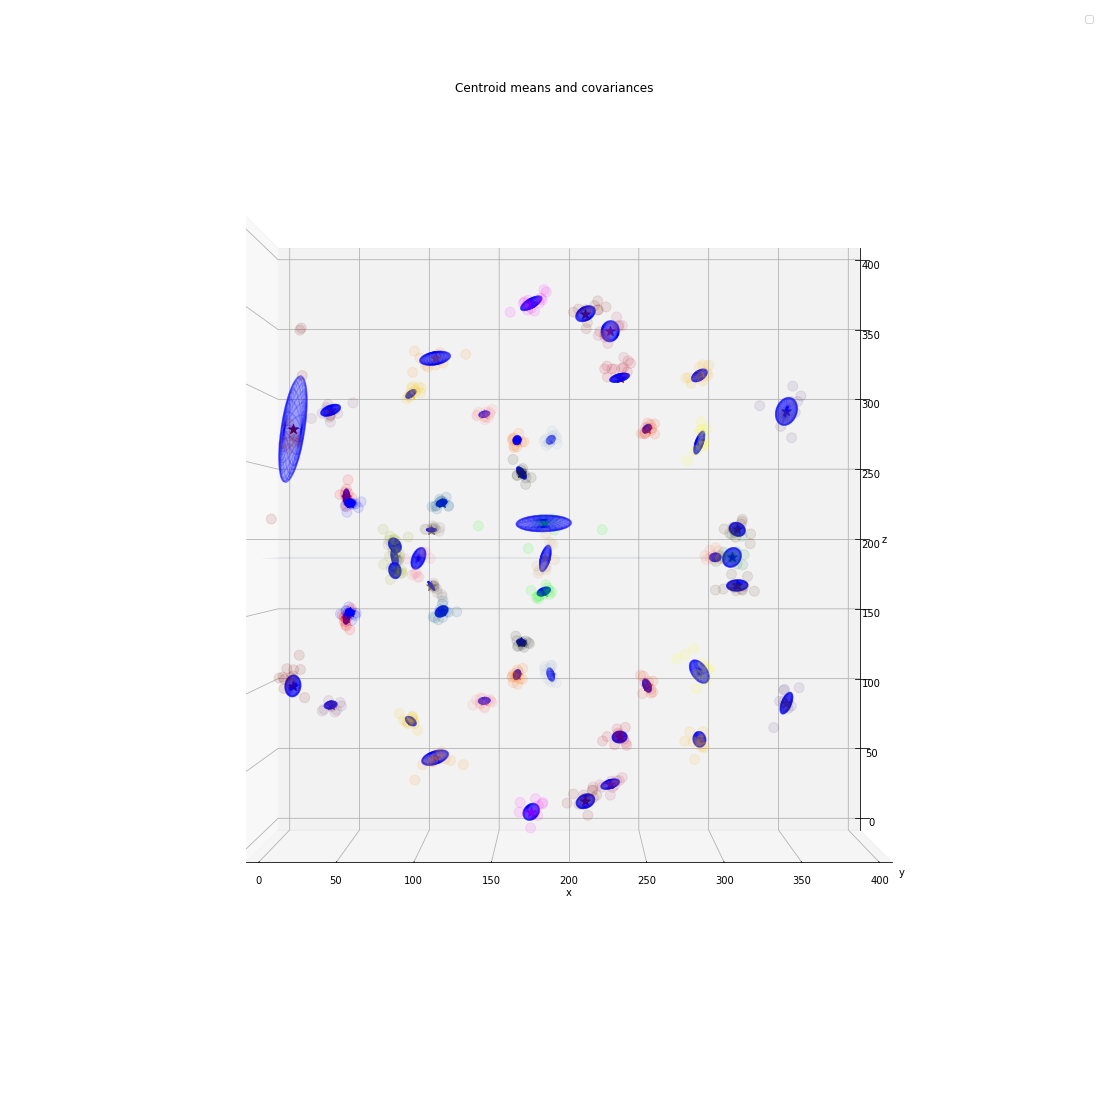

In [41]:
plot_centroid_means_and_covars_3d(instance_centroids=instance_centroids_deviations_allstructures_rel2canon_outlier_removed,
                                 nominal_locations=updated_nominal_locations_rel2canon,
                                 canonical_centroid=updated_canonical_centroid_rel2atlas,
                                  show_canonical_centroid=False,
                                  canonical_normal=[0,0,1],
                                 colors={name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
                                         for name_s in instance_centroids_deviations_allstructures_rel2canon_outlier_removed.keys()})

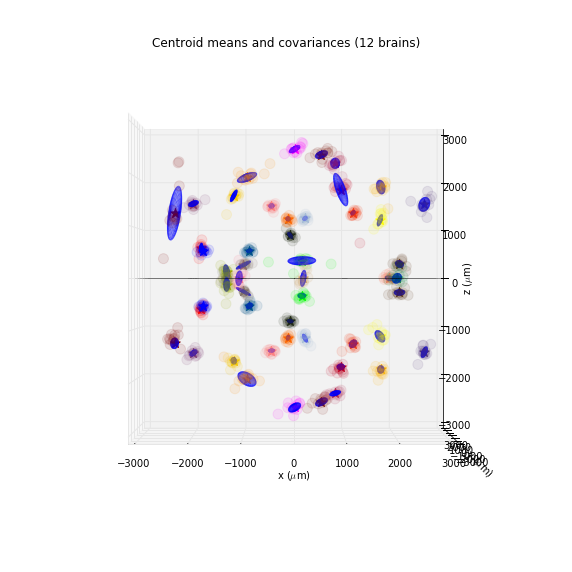

In [79]:
# Unit in microns, center at (0,0,0)

updated_canonical_centroid_rel2atlas_um = updated_canonical_centroid_rel2atlas * XY_PIXEL_DISTANCE_LOSSLESS * 32

instance_centroids_deviations_allstructures_rel2canon_outlier_removed_um = \
{s: v * XY_PIXEL_DISTANCE_LOSSLESS * 32
 for s, v in instance_centroids_deviations_allstructures_rel2canon_outlier_removed.iteritems()}

updated_nominal_locations_rel2canon_um = {s: v * XY_PIXEL_DISTANCE_LOSSLESS * 32
                                          for s, v in updated_nominal_locations_rel2canon.iteritems()}

plot_centroid_means_and_covars_3d(instance_centroids=instance_centroids_deviations_allstructures_rel2canon_outlier_removed_um,
                                 nominal_locations=updated_nominal_locations_rel2canon_um,
                                 canonical_centroid=(0,0,0),
                                  show_canonical_centroid=False,
                                  canonical_normal=[0,0,1],
                                 colors={name_s: np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255.
                                        for name_s in instance_centroids_deviations_allstructures_rel2canon_outlier_removed.keys()},
                                 xlim=[-3000, 3000],
                                 ylim=[-3000, 3000],
                                 zlim=[-3000, 3000],
                                 xlabel='x ($\mu$m)',
                                 ylabel='y ($\mu$m)',
                                 zlabel='z ($\mu$m)',
                                 title='Centroid means and covariances (12 brains)')

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

for ss in sorted(all_known_structures_sided):
# for ss in ['PBG_L', 'PBG_R']:

    fig = plt.figure(figsize=(20, 20));
#     fig = plt.figure();
    ax = fig.add_subplot(111, projection='3d')
    
#     for name_s, centroids_rel2fixed in instance_centroids_rel2fixed.iteritems():
#         if name_s == ss:
# #         if convert_to_original_name(name_s) == ss:
# #         if True:
#             centroids = np.array(centroids_rel2fixed)
#             ax.scatter(centroids[:,0], centroids[:,1], centroids[:,2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., 
#                        marker='o', s=100, alpha=.1)

#             c = canonical_locations_rel2fixed[name_s]
#             ax.scatter(c[0], c[1], c[2], 
#                        color=np.array(name_unsided_to_color[convert_to_original_name(name_s)])/255., marker='*', s=100)

#     #     # Plot uncerntainty ellipsoids
#     #     u = np.linspace(0.0, 2.0 * np.pi, 100)
#     #     v = np.linspace(0.0, np.pi, 100)
#     #     x = radii_allStructures[name_s][0] * np.outer(np.cos(u), np.sin(v))
#     #     y = radii_allStructures[name_s][1] * np.outer(np.sin(u), np.sin(v))
#     #     z = radii_allStructures[name_s][2] * np.outer(np.ones_like(u), np.cos(v))
#     #     for i in range(len(u)):
#     #         for j in range(len(v)):
#     #             [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], ellipsoid_matrix_allStructures[name_s]) + c

#     #     ax.plot_surface(x, y, z, color='b')
#     #     ax.plot_wireframe(x, y, z,  rstride=4, cstride=4, color='b', alpha=0.2)

#     ax.scatter(canonical_centroid_rel2fixed[0], canonical_centroid_rel2fixed[1], canonical_centroid_rel2fixed[2], 
#                color=(0,0,0), marker='^', s=200, alpha=.3)

    # Plot mid-sagittal plane
    ax.plot_surface(canonical_midplane_xx, canonical_midplane_yy, canonical_midplane_z, alpha=.1)

    #######################################################

    for name_s, centroids_rel2atlas in adjusted_structure_centroids_rel2atlas.iteritems():   
        if name_s == ss:
#         if convert_to_original_name(name_s) == ss:
#         if True:
            for st, c in centroids_rel2atlas.iteritems():
                ax.scatter(c[0], c[1], c[2], 
                       color=np.array(stack_to_color[st])/255., 
                       marker='o', s=100, alpha=1, label=st)

    ##########################################################

    c = canonical_locations_rel2fixed[ss]
    ax.scatter(c[0], c[1], c[2], color=(0,0,0), marker='*', s=100, alpha=1.)
    
    ############################################################
    
    c = new_mean_centroids_rel2atlas_allstructures[ss]
    ax.scatter(c[0], c[1], c[2], color=(0,0,0), marker='^', s=100, alpha=1.)
    
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    # ax.set_axis_off()
    ax.set_xlim3d([0, 400]);
    ax.set_ylim3d([0, 400]);
    ax.set_zlim3d([0, 400]);
    ax.view_init(azim = -90,elev = -45)
    ax.set_aspect(1.0)
    plt.legend()
    plt.title(ss);
    plt.tight_layout();
    plt.show()

# Measure brain-to-brain variation

In [45]:
rms_x = np.sqrt(np.mean([x[0]**2 for v in instance_centroids_deviations_allstructures_rel2nominal_um.values() for x in v.values()]))
rms_y = np.sqrt(np.mean([x[1]**2 for v in instance_centroids_deviations_allstructures_rel2nominal_um.values() for x in v.values()]))
rms_z = np.sqrt(np.mean([x[2]**2 for v in instance_centroids_deviations_allstructures_rel2nominal_um.values() for x in v.values()]))
rms_xyz = np.sqrt(np.mean([np.linalg.norm(x)**2 for v in instance_centroids_deviations_allstructures_rel2nominal_um.values() for x in v.values()]))
print rms_x, rms_y, rms_z, rms_xyz

92.05865230601559 99.9485376943505 116.4905084033713 178.9819661298724


### 3-d variation

In [59]:
cutoff_um = 600 # Only show those with deviation less than 600um

instance_centroids_xyz_deviations_all_stacks_allstructures_rel2nominal_um = defaultdict(dict)
for name_s, x_all_stacks in instance_centroids_deviations_allstructures_rel2nominal_um.iteritems():
    for stack, x in x_all_stacks.iteritems(): 
        if np.linalg.norm(x) >= cutoff_um:
            print 'Removed %s from %s because deviation %d um is more than %d um.' % (name_s, stack, np.linalg.norm(x) , cutoff_um)
        else:
            instance_centroids_xyz_deviations_all_stacks_allstructures_rel2nominal_um[stack][name_s] =  np.linalg.norm(x)
instance_centroids_xyz_deviations_all_stacks_allstructures_rel2nominal_um.default_factory = None

Removed VLL_R from MD603 because deviation 774 um is more than 600 um.
Removed Sp5O_R from MD603 because deviation 1122 um is more than 600 um.
Removed 6N_R from MD590 because deviation 640 um is more than 600 um.
Removed 6N_R from MD599 because deviation 660 um is more than 600 um.
Removed SNC_R from MD593 because deviation 1024 um is more than 600 um.
Removed SNC_R from MD585 because deviation 904 um is more than 600 um.
Removed SNC_R from MD595 because deviation 1118 um is more than 600 um.


In [60]:
q = defaultdict(list)
for stack, x_all_structures in instance_centroids_xyz_deviations_all_stacks_allstructures_rel2nominal_um.iteritems():
    for name_s, x in x_all_structures.iteritems():
        q[name_s].append(x)
rms_3d_all_structures = {name_s: np.sqrt(np.mean(np.array(qq)**2)) for name_s, qq in q.iteritems()}

In [199]:
pd.Series(rms_3d_all_structures).to_csv('/home/yuncong/population_rms_3d_all_structures.csv')

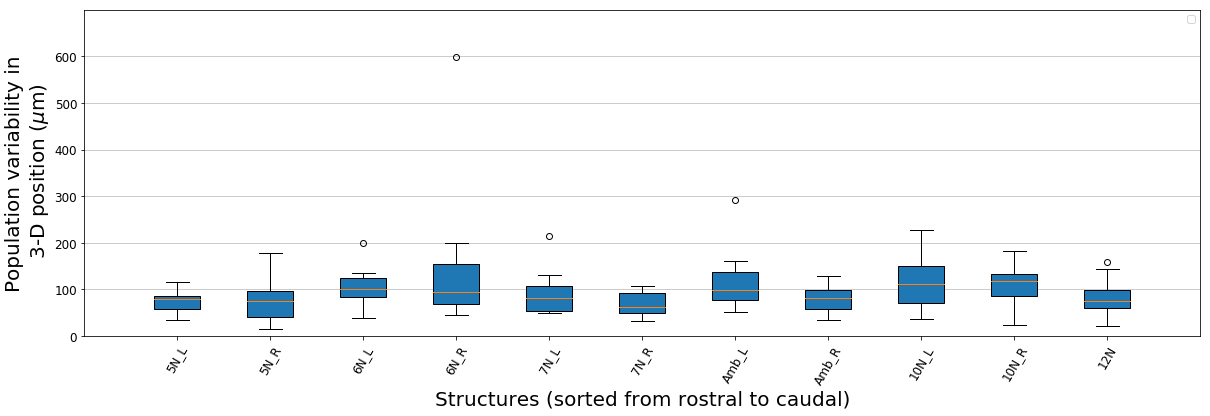

In [69]:
structures_sided_sorted_by_rostral_caudal_position_motor_nuclei = ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']
plot_by_stack_by_structure(instance_centroids_xyz_deviations_all_stacks_allstructures_rel2nominal_um, 
                          structures=structures_sided_sorted_by_rostral_caudal_position_motor_nuclei,
                          yticks=np.arange(0, 700, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position_motor_nuclei)],
                          xlabel='Structures (sorted from rostral to caudal)',
                           ylabel='Population variability in\n 3-D position ($\mu$m)',
                          style='boxplot');

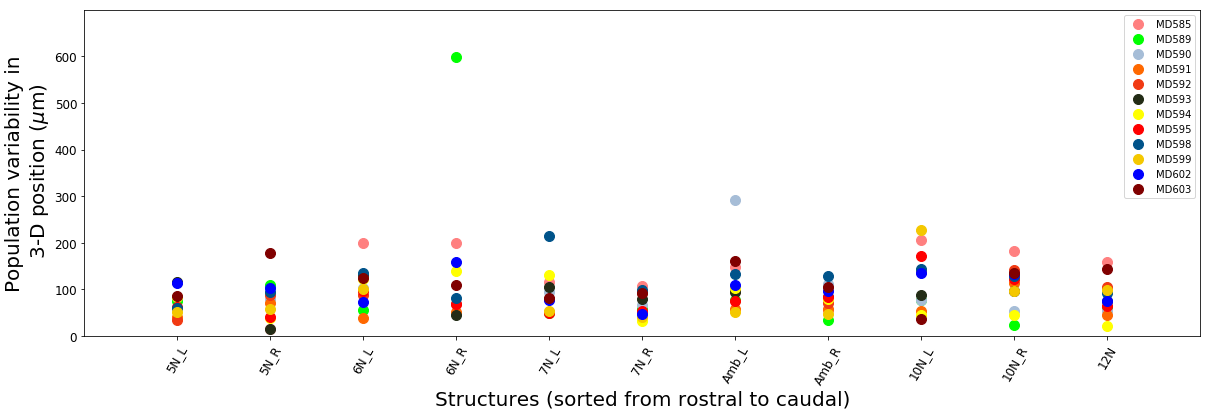

In [68]:
structures_sided_sorted_by_rostral_caudal_position_motor_nuclei = ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']
plot_by_stack_by_structure(instance_centroids_xyz_deviations_all_stacks_allstructures_rel2nominal_um, 
                          structures=structures_sided_sorted_by_rostral_caudal_position_motor_nuclei,
                          yticks=np.arange(0, 700, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position_motor_nuclei)],
                          xlabel='Structures (sorted from rostral to caudal)',
                           ylabel='Population variability in\n 3-D position ($\mu$m)');

### Rostral caudal

In [200]:
cutoff_um = 300 # Only show those with deviation less than 400um

instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um = defaultdict(dict)
for name_s, x_all_stacks in instance_centroids_deviations_allstructures_rel2nominal_um.iteritems():
    for stack, x in x_all_stacks.iteritems(): 
        if abs(x[0]) >= cutoff_um:
            print 'Removed %s from %s because deviation %d um is more than %d um.' % (name_s, stack, x[0], cutoff_um)
        else:
            instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um[stack][name_s] = x[0]
instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um.default_factory = None

Removed PBG_L from MD598 because deviation -397 um is more than 300 um.
Removed 4N_R from MD590 because deviation -399 um is more than 300 um.
Removed PBG_R from MD599 because deviation 399 um is more than 300 um.
Removed Sp5O_R from MD603 because deviation 359 um is more than 300 um.
Removed VCA_L from MD595 because deviation -301 um is more than 300 um.
Removed 6N_R from MD589 because deviation 594 um is more than 300 um.
Removed 6N_R from MD599 because deviation -657 um is more than 300 um.
Removed SNC_R from MD598 because deviation 368 um is more than 300 um.
Removed 4N_L from MD602 because deviation -435 um is more than 300 um.


In [202]:
q = defaultdict(list)
for stack, x_all_structures in instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um.iteritems():
    for name_s, x in x_all_structures.iteritems():
        q[name_s].append(x)
# std_x_all_structures = {name_s: np.std(qq) for name_s, qq in q.iteritems()}
rms_x_all_structures = {name_s: np.sqrt(np.mean(np.array(qq)**2)) for name_s, qq in q.iteritems()}

In [203]:
pd.Series(rms_x_all_structures).to_csv('/home/yuncong/population_rms_x_all_structures.csv')

In [219]:
pd.DataFrame(instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um).to_csv('/home/yuncong/instance_centroids_distance_x_from_mean_all_stacks_all_structures_um.csv')

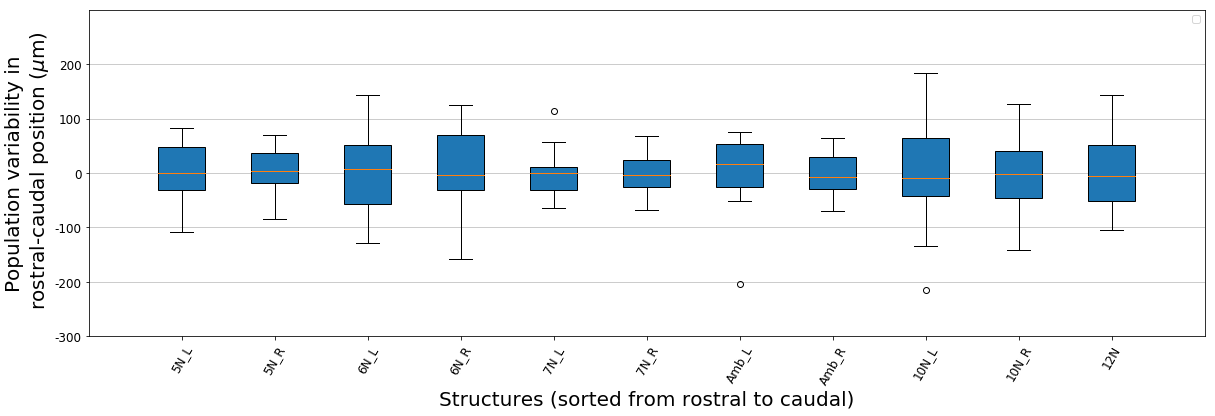

In [170]:
structures_sided_sorted_by_rostral_caudal_position_motor_nuclei = ['5N_L', '5N_R', '6N_L', '6N_R', '7N_L', '7N_R', 'Amb_L', 'Amb_R', '10N_L', '10N_R', '12N']
plot_by_stack_by_structure(instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um, 
                          structures=structures_sided_sorted_by_rostral_caudal_position_motor_nuclei,
                          yticks=np.arange(-300, 300, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position_motor_nuclei)],
                          xlabel='Structures (sorted from rostral to caudal)',
                           ylabel='Population variability in\n rostral-caudal position ($\mu$m)',
                          style='boxplot')

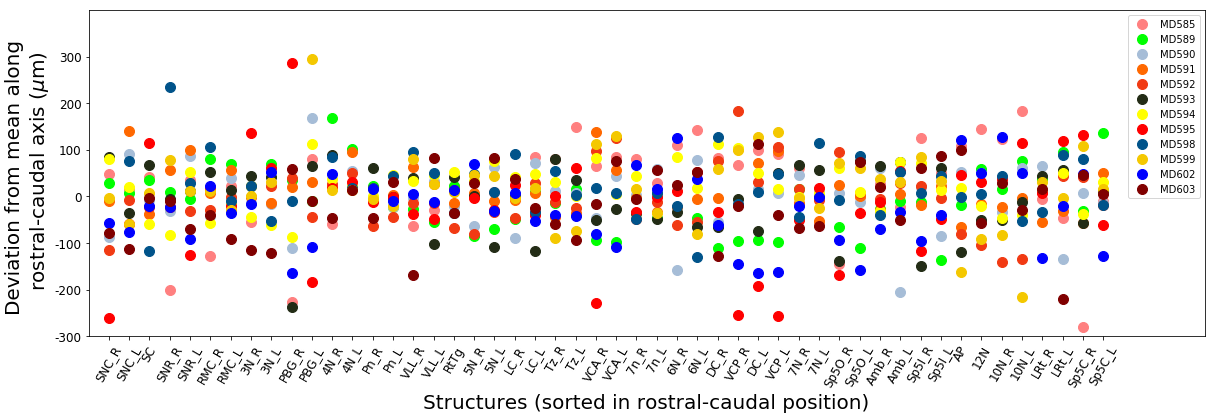

In [29]:
plot_by_stack_by_structure(instance_centroids_x_deviations_all_stacks_allstructures_rel2nominal_um, 
                          structures=structures_sided_sorted_by_rostral_caudal_position,
                          yticks=np.arange(-300, 300+1, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position)+4],
                          xlabel='Structures (sorted in rostral-caudal position)',
                           ylabel='Deviation from mean along \n rostral-caudal axis ($\mu$m)')

### Dorsal ventral

In [50]:
cutoff_um = 300 # Only show those with deviation less than 400um

instance_centroids_y_deviations_all_stacks_allstructures_rel2nominal_um = defaultdict(dict)
for name_s, x_all_stacks in instance_centroids_deviations_allstructures_rel2nominal_um.iteritems():
    for stack, x in x_all_stacks.iteritems(): 
        if abs(x[1]) >= cutoff_um:
            print 'Removed %s from %s because deviation %d um is more than %d um.' % (name_s, stack, x[1], cutoff_um)
        else:
            instance_centroids_y_deviations_all_stacks_allstructures_rel2nominal_um[stack][name_s] = x[1]
instance_centroids_y_deviations_all_stacks_allstructures_rel2nominal_um.default_factory = None

Removed VLL_R from MD603 because deviation 680 um is more than 300 um.
Removed Sp5C_R from MD603 because deviation -319 um is more than 300 um.
Removed SNR_R from MD603 because deviation 319 um is more than 300 um.
Removed 6N_R from MD590 because deviation 576 um is more than 300 um.
Removed SNC_R from MD603 because deviation 317 um is more than 300 um.
Removed SNC_R from MD593 because deviation -469 um is more than 300 um.
Removed SNC_R from MD590 because deviation 555 um is more than 300 um.
Removed SNC_R from MD595 because deviation 444 um is more than 300 um.
Removed SNC_R from MD598 because deviation -406 um is more than 300 um.


In [51]:
q = defaultdict(list)
for stack, x_all_structures in instance_centroids_y_deviations_all_stacks_allstructures_rel2nominal_um.iteritems():
    for name_s, x in x_all_structures.iteritems():
        q[name_s].append(x)
# std_y_all_structures = {name_s: np.std(qq) for name_s, qq in q.iteritems()}
rms_y_all_structures = {name_s: np.sqrt(np.mean(np.array(qq)**2)) for name_s, qq in q.iteritems()}

In [54]:
import pandas as pd

In [ ]:
pd.Series(rms_y_all_structures).to_csv('/home/yuncong/population_rms_y_all_structures.csv')

In [ ]:
pd.DataFrame(instance_centroids_y_deviations_all_stacks_allstructures_rel2nominal_um).to_csv('/home/yuncong/instance_centroids_distance_y_from_mean_all_stacks_all_structures_um.csv')

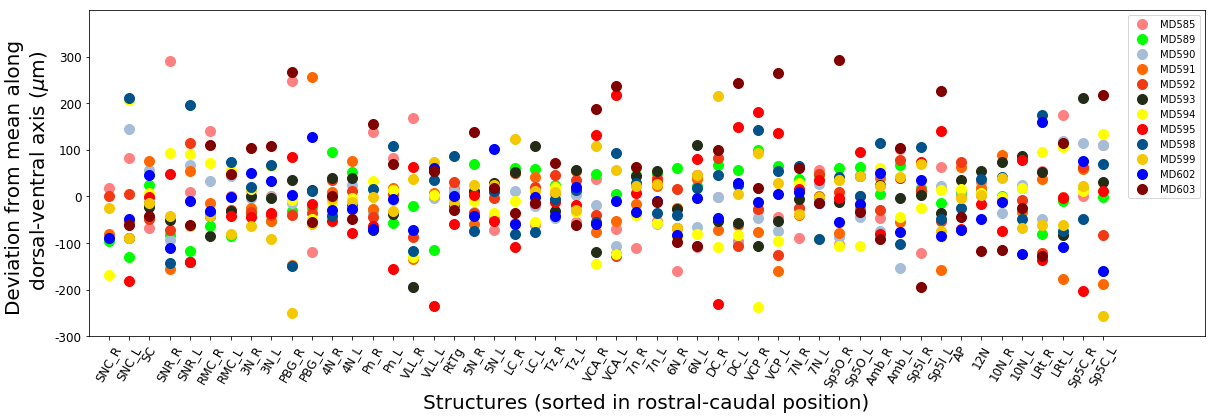

In [56]:
plot_by_stack_by_structure(instance_centroids_y_deviations_all_stacks_allstructures_rel2nominal_um, 
                          structures=structures_sided_sorted_by_rostral_caudal_position,
                          yticks=np.arange(-300, 300+1, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position)+4],
                          xlabel='Structures (sorted in rostral-caudal position)',
                           ylabel='Deviation from mean along \n dorsal-ventral axis ($\mu$m)');

### Lateral medial

In [71]:
cutoff_um = 300 # Only show those with deviation less than 400um

instance_centroids_z_deviations_all_stacks_allstructures_rel2nominal_um = defaultdict(dict)
for name_s, x_all_stacks in instance_centroids_deviations_allstructures_rel2nominal_um.iteritems():
    for stack, x in x_all_stacks.iteritems(): 
        if abs(x[2]) >= cutoff_um:
            print 'Removed %s from %s because deviation %d um is more than %d um.' % (name_s, stack, x[2], cutoff_um)
        else:
            instance_centroids_z_deviations_all_stacks_allstructures_rel2nominal_um[stack][name_s] = x[2]
instance_centroids_z_deviations_all_stacks_allstructures_rel2nominal_um.default_factory = None

Removed PBG_L from MD598 because deviation 397 um is more than 300 um.
Removed VLL_R from MD603 because deviation -329 um is more than 300 um.
Removed Sp5O_R from MD603 because deviation -1021 um is more than 300 um.
Removed 3N_L from MD591 because deviation -341 um is more than 300 um.
Removed SNC_R from MD593 because deviation 906 um is more than 300 um.
Removed SNC_R from MD585 because deviation 903 um is more than 300 um.
Removed SNC_R from MD594 because deviation 441 um is more than 300 um.
Removed SNC_R from MD595 because deviation -992 um is more than 300 um.
Removed Sp5I_R from MD585 because deviation -398 um is more than 300 um.
Removed 3N_R from MD593 because deviation -387 um is more than 300 um.
Removed IC from MD603 because deviation 305 um is more than 300 um.
Removed SC from MD603 because deviation 331 um is more than 300 um.


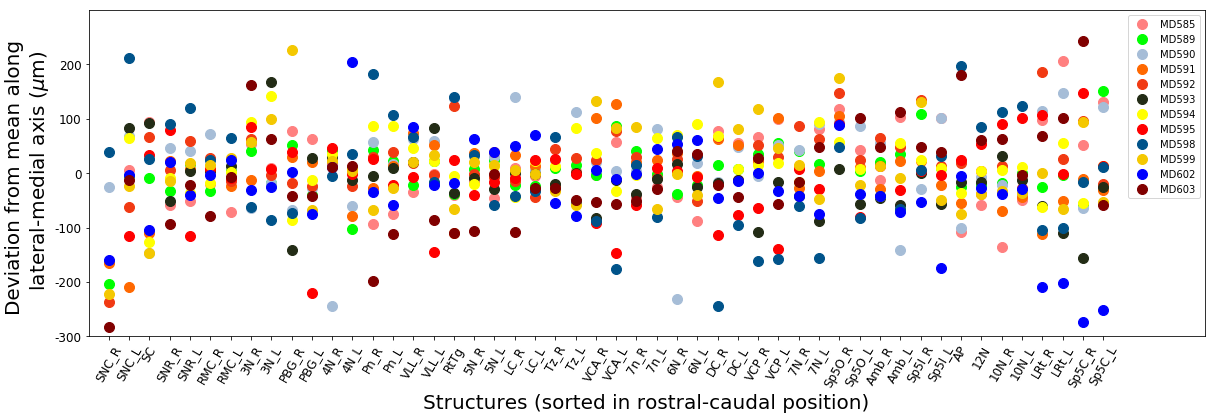

In [72]:
plot_by_stack_by_structure(instance_centroids_z_deviations_all_stacks_allstructures_rel2nominal_um, 
                          structures=structures_sided_sorted_by_rostral_caudal_position,
                          yticks=np.arange(-300, 300, 100),
                           yticklabel_fmt='%d',
                          stack_to_color=stack_to_color, 
                          xticks_fontsize=12,
                          yticks_fontsize=12,
                          xlim=[-1, len(structures_sided_sorted_by_rostral_caudal_position)+4],
                          xlabel='Structures (sorted in rostral-caudal position)',
                           ylabel='Deviation from mean along \n lateral-medial axis ($\mu$m)');

In [73]:
q = defaultdict(list)
for stack, x_all_structures in instance_centroids_z_deviations_all_stacks_allstructures_rel2nominal_um.iteritems():
    for name_s, x in x_all_structures.iteritems():
        q[name_s].append(x)
# std_z_all_structures = {name_s: np.std(qq) for name_s, qq in q.iteritems()}
rms_z_all_structures = {name_s: np.sqrt(np.mean(np.array(qq)**2)) for name_s, qq in q.iteritems()}

In [209]:
pd.Series(rms_z_all_structures).to_csv('/home/yuncong/population_rms_z_all_structures.csv')

In [221]:
pd.DataFrame(instance_centroids_z_deviations_all_stacks_allstructures_rel2nominal_um).to_csv('/home/yuncong/instance_centroids_distance_z_from_mean_all_stacks_all_structures_um.csv')

# Measure non-isotropy of the variation

In [36]:
nonisotropy = {}
for s in sorted(all_known_structures_sided):
    std_xyz = np.array([std_x_all_structures[s], std_y_all_structures[s], std_z_all_structures[s]])
    print s, std_xyz
    nonisotropy[s] = std_xyz.max() / std_xyz.min()

10N_L [103.42021275  61.49075928  53.58335684]
10N_R [75.95924781 55.40109885 66.16398393]
12N [68.32049891 43.26712767 42.4369983 ]
3N_L [54.9774235  56.69491294 74.26902113]
3N_R [58.37954893 44.15145058 67.13667356]
4N_L [30.67232268 41.75680632 73.28506195]
4N_R [60.292208   40.41822965 75.05047272]
5N_L [56.57086577 44.44626066 30.97223407]
5N_R [49.10816723 56.42873457 42.33329347]
6N_L [74.36427724 70.3205031  48.07525602]
6N_R [81.55248706 56.54337125 78.21028726]
7N_L [48.31151636 47.20077196 77.195891  ]
7N_R [41.47692179 43.54197388 40.73375446]
7n_L [35.19943254 41.31086789 46.49505517]
7n_R [42.28710409 47.19202628 40.6038385 ]
AP [88.05749203 44.79036367 93.87419756]
Amb_L [73.53499711 81.86721513 72.94940218]
Amb_R [40.78454054 61.85506443 39.63337979]
DC_L [102.55766465 104.59925229  51.74174187]
DC_R [ 84.42462719 110.23268793 101.1681278 ]
IC [ 49.89508895  91.57875272 121.00342339]
LC_L [54.74216317 50.35767286 29.48993117]
LC_R [45.45502929 66.54855239 57.4898457 ]


In [37]:
nonisotropy['VLL_L']

1.6981540215350739

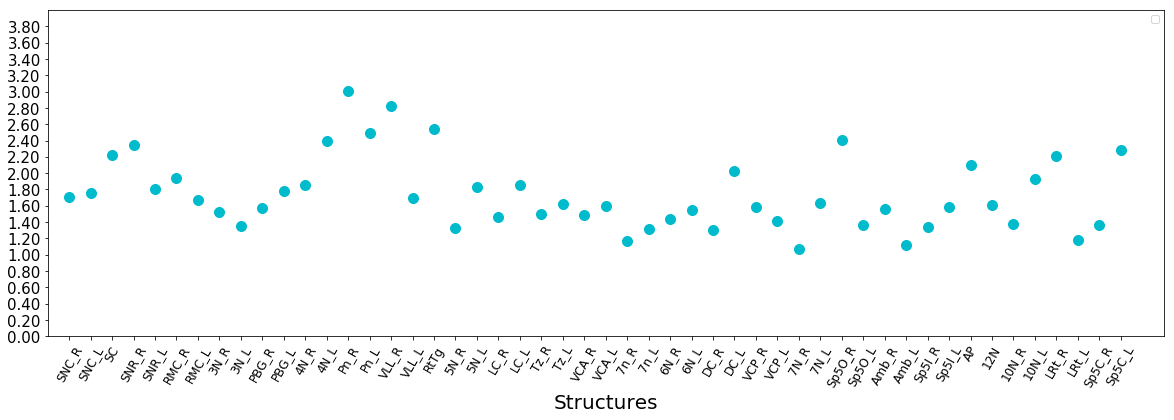

In [50]:
plot_by_stack_by_structure({'': nonisotropy}, structures=structures_sided_sorted_by_rostral_caudal_position,
                          yticks=np.arange(0,4,0.2))